<a href="https://colab.research.google.com/github/wisrovi/SAM/blob/master/Red%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Vamos a necesitar usar la GPU de la maquina


In [4]:
!pip3 install dlib
!pip install cmake
!pip3 --no-cache-dir install face_recognition

     |████████████████████████████████| 100.2MB 1.3MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566176 sha256=bb69ec325797047d09f7b169e6234ca4c70957cd63b1d271b492a0d29db9d55c
  Stored in directory: /tmp/pip-ephem-wheel-cache-w89jt69r/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
import dlib
import face_recognition

In [6]:
raiz = '/content/drive/'

#API google colab con google drive
from google.colab import drive
drive.mount(raiz)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
def verContenidoCarpeta():
  a = !ls "/content/drive/My Drive/Redes Neuronales"
  return a

In [8]:
a = verContenidoCarpeta()
if len(a)>0:
  try:
    if str(a[0]).index('cannot access') > 0:
      print("El directorio no existe, creando el directorio")
      !mkdir "/content/drive/My Drive/Redes Neuronales"
  except:
    pass
else:
  print("El directorio esta vacio")

El directorio esta vacio


In [9]:
verContenidoCarpeta()

[]

In [10]:
def descargarArchivos():
  !git clone https://github.com/wisrovi/SAM "/content/drive/My Drive/Redes Neuronales"

descargarArchivos()

fatal: destination path '/content/drive/My Drive/Redes Neuronales' already exists and is not an empty directory.


In [11]:
verContenidoCarpeta()

[]

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image

<IPython.core.display.Javascript object>

Saved to wisrovi.jpg


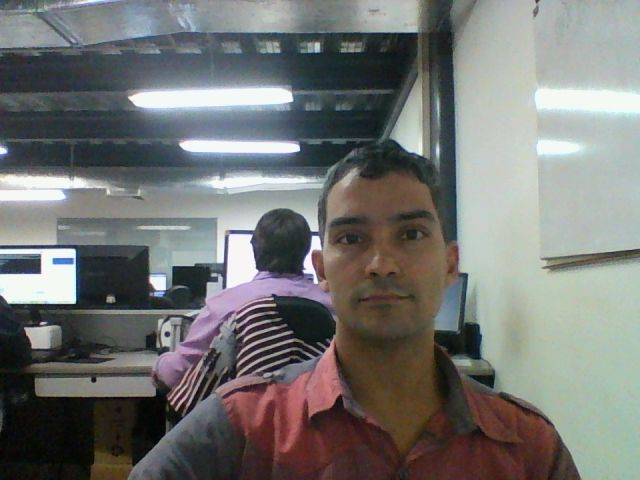

In [13]:
nombreGuardarImagen = "wisrovi.jpg"
try:
  filename = take_photo(nombreGuardarImagen)
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

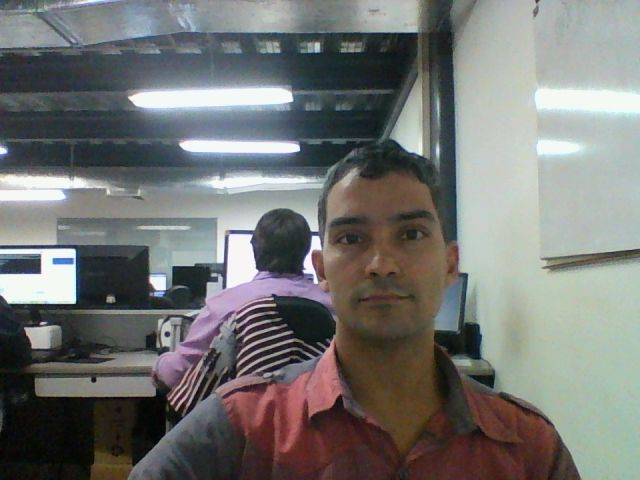

In [14]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(nombreGuardarImagen, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [0]:
from google.colab import files
files.upload()

Saving deploy.prototxt.txt to deploy.prototxt.txt
Saving OpenCV_3.py to OpenCV_3.py
Saving res10_300x300_ssd_iter_140000.caffemodel to res10_300x300_ssd_iter_140000.caffemodel


In [0]:
from OpenCV_3 import OpenCV_3
detecFaces = OpenCV_3()
detecFaces.setConfianzaDeteccion(0.40)

In [0]:
frame = cv2.imread(nombreGuardarImagen, cv2.IMREAD_COLOR)

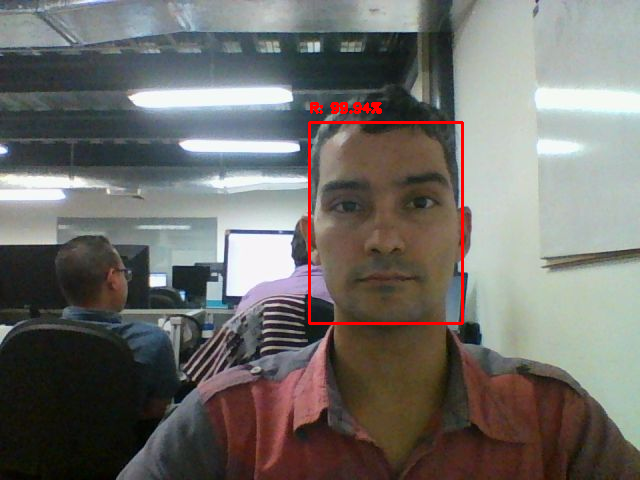

In [118]:
listadoCoordenadasRostros = detecFaces.detectarRostros(frame)
for (startX, startY, endX, endY, confianzaEsteRostro) in listadoCoordenadasRostros:
  cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

  text = "R: " + "{:.2f}%".format(confianzaEsteRostro * 100)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

  rostroColor = frame[startY:endY, startX:endX]
cv2_imshow(frame)

RuntimeError: ignored

In [93]:
try:
  !rm -r "/content/drive/My Drive/Redes Neuronales"
except:
  pass

rm: cannot remove '/content/drive/My Drive/Redes Neuronales': No such file or directory
